In [42]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [43]:
load_dotenv()

model_essay = ChatGroq(model="qwen/qwen3-32b")
model = ChatOpenAI(model='gpt-4o-mini')

In [44]:
class EvaluationSchema(BaseModel):
    feedback: str= Field(description='Detailed feedback for the essay')
    score: int=Field(description='Score out of 10', ge=0, le=10)

structed_model = model.with_structured_output(EvaluationSchema)

In [45]:
class UPSCState(TypedDict):
    topic : str
    essay:str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback : str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [46]:
prompt_essay = PromptTemplate(
    template="""Please write an essay on the topic: {topic}
    Inclue good analogies and real world examples""",
    input_variables=['topic']
)
parser = StrOutputParser()
chain = prompt_essay | model | parser

def gen_essay(state: UPSCState):
    topic = state['topic']
    essay = chain.invoke(topic)
    return {'essay':essay}

In [47]:
def evaluate_language(state:UPSCState):
    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign score out of 10 \n {state["essay"]}"
    output = structed_model.invoke(prompt)

    return {'language_feedback': output.feedback, "individual_scores":[output.score] }

In [48]:
def evaluate_analysis(state:UPSCState):
    prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign score out of 10 \n {state["essay"]}"
    output = structed_model.invoke(prompt)

    return {'analysis_feedback': output.feedback, "individual_scores":[output.score] }

In [49]:
def evaluate_thought(state:UPSCState):
    prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign score out of 10 \n {state["essay"]}"
    output = structed_model.invoke(prompt)

    return {'clarity_feedback': output.feedback, "individual_scores":[output.score] }

In [50]:
def final_evaluation(state:UPSCState):
    prompt = f'Based on following feedback, create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, "avg_score":avg_score }

In [51]:
graph = StateGraph(UPSCState)

#add nodes
graph.add_node('gen_essay', gen_essay)
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

graph.add_edge(START, 'gen_essay')
graph.add_edge('gen_essay', 'evaluate_language')
graph.add_edge('gen_essay', 'evaluate_analysis')
graph.add_edge('gen_essay', 'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()


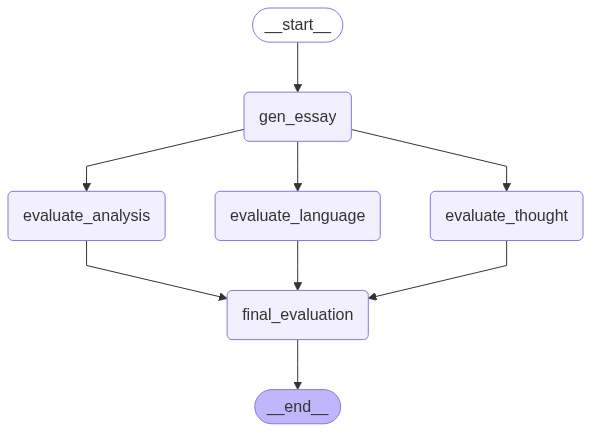

In [52]:
workflow

In [54]:
initial_state = {
    'topic' : 'The scope of AI engineer and tool stack required'
}
workflow.invoke(initial_state)

{'topic': 'The scope of AI engineer and tool stack required',
 'essay': "## The Scope of AI Engineer and the Tool Stack Required\n\nArtificial Intelligence (AI) is no longer a vague futuristic concept; it is a defining force of our present. From Siri and Alexa to advanced chatbots and autonomous vehicles, AI permeates various sectors, including healthcare, finance, entertainment, and education. At the core of this transformative technology lies the AI engineer, a pivotal figure responsible for designing, developing, and implementing AI models and solutions. To comprehend the full scope of an AI engineer’s role and the requisite tool stack, we must delve into both the foundational tasks they undertake and the technology they leverage.\n\n### Understanding the Role of an AI Engineer\n\nAnalogous to a chef creating a recipe, an AI engineer synthesizes data, algorithms, and computational power to create AI solutions tailored to specific problems. Just as a chef must understand their ingred